In [59]:
import numpy as np
import pandas as pd
import sklearn as ktl
import pickle
import matplotlib.pylab as plt
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

In [41]:
bol = pd.read_csv("/Users/hendrixperalta/Desktop/bolivia/data/GeoDS4Bolivia.csv")
bol = bol.rename(columns={"asdf_id":"id"})

#list(bol.columns)
offset = 1000000  
sat = pd.read_csv("data/egdp/satelite_data.csv")
sat["lnEGDPpc2012"] = np.log((sat["egdp2012"]/ bol["pop2012"])+offset)


df = pd.merge(bol, sat, on="id", how="outer")

df["total_land2012"] = df["agr_land2012"] + df["urb_land2012"]
df["perUrb_land"] = df["urb_land2012"] / df["total_land2012"]

# **Data exploration**

In [89]:
short_df = df[["imds","ln_t400NTLpc2012", "tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'pm25_2012', 'land_temp2012', "urb_land2012","agr_land2012"]]
short_df.isna().sum()

imds                 0
ln_t400NTLpc2012     0
tr400_pop2012        0
lnEGDPpc2012         0
perUrb_land         98
pm25_2012            0
land_temp2012        0
urb_land2012         0
agr_land2012         0
dtype: int64

In [84]:
short_df.describe()

,imds,ln_t400NTLpc2012,tr400_pop2012,lnEGDPpc2012,perUrb_land,pm25_2012,land_temp2012
count,339.000000,339.000000,3.390000e+02,3.390000e+02,241.000000,339.000000,339.000000
mean,51.050442,13.033028,2.972431e+04,1.381551e+01,0.370578,23.561684,297.836346
std,6.771824,1.671621,1.065526e+05,1.812101e-08,0.358636,6.765622,3.453744
min,35.700001,0.856095,5.186144e+02,1.381551e+01,0.000000,8.257901,287.125211
25%,47.000000,12.050438,5.923900e+03,1.381551e+01,0.000000,18.052961,295.856684
50%,50.500000,13.118243,1.087926e+04,1.381551e+01,0.292286,21.915591,298.305783
75%,54.850001,14.268402,2.000315e+04,1.381551e+01,0.729234,28.731712,300.579665
max,80.199997,17.071051,1.428180e+06,1.381551e+01,1.000000,38.466365,305.141851


In [85]:
#plt.style.available

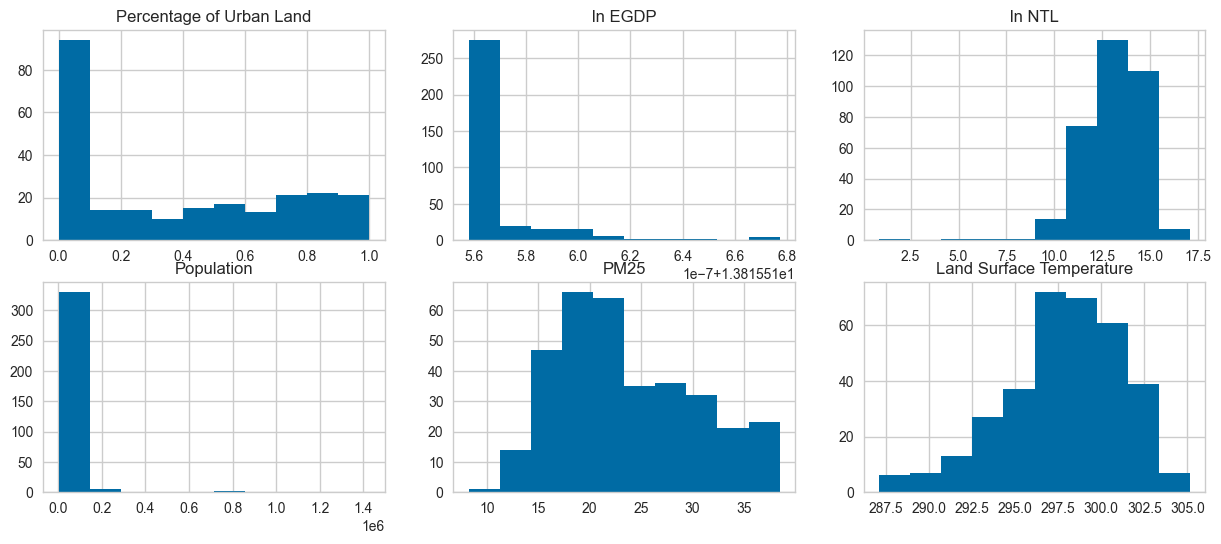

In [87]:
plt.style.use("tableau-colorblind10")

fig, ((ax0, ax1, ax2),(ax3, ax4, ax5)) = plt.subplots(nrows=2,
                                                     ncols=3,
                                                     figsize=(15,6)
                                                     )
ax0.hist(df["perUrb_land"])
ax0.set(title="Percentage of Urban Land")

ax1.hist(df["lnEGDPpc2012"])
ax1.set(title="ln EGDP")

ax2.hist(df["ln_t400NTLpc2012"])
ax2.set(title="ln NTL")

ax3.hist(df["tr400_pop2012"])
ax3.set(title= "Population")

ax4.hist(df["pm25_2012"])
ax4.set(title= "PM25")

ax5.hist(df["land_temp2012"])
ax5.set(title= "Land Surface Temperature");


# **Regression models**

### Linear model

In [3]:
x = df[["ln_t400NTLpc2012", "tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'pm25_2012', 'land_temp2012']].fillna(0)
y = df['imds']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

model = LinearRegression()
model.fit(x_train,y_train)
lr = model.score(x_test, y_test)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#print("Mean Squared Error:", mse)
#print("R^2 Score:", r2)

### Ridge  model

In [4]:
x = df[["ln_t400NTLpc2012", "tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'pm25_2012', 'land_temp2012']].fillna(0)
y = df['imds']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rid_model = linear_model.Ridge()
rid_model.fit(x_train, y_train)
ri = rid_model.score(x_test, y_test)

### Random Forest Regressor model

In [5]:
x = df[["ln_t400NTLpc2012", "tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'pm25_2012', 'land_temp2012']].fillna(0)
y = df['imds']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)
rf = rf_model.score(x_test, y_test)

### Results 

In [6]:
print("R2 for the regressor models")
print(f" Linear model: {lr*100:.2f}%")
print(f" Ridger model: {ri*100:.2f}%")
print(f" Random Forest model: {rf*100:.2f}%")

R2 for the regressor models
 Linear model: 35.59%
 Ridger model: 34.60%
 Random Forest model: 60.61%


# **Categorical analysis**

In [7]:
quantile_labels = ["low", 'medium-low', 'medium-high', 'high']
df["imds_quantile"] = pd.qcut(df["imds"], q=4, labels=quantile_labels)
#df["imds_quantile"]

In [8]:
x = df[["ln_t400NTLpc2012", "tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'pm25_2012', 'land_temp2012']].fillna(0)
y = df['imds_quantile']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

clf = RandomForestClassifier()
#clf.get_params()
clf.fit(x_train,y_train);

y_preds = clf.predict(x_test)

#evaluate the model
#print(f" Train data score: {clf.score(x_train, y_train)*100:.2f}%")
print(f" Test data score: {clf.score(x_test, y_test)*100:.2f}%")
rf_cl = clf.score(x_test, y_test)

 Test data score: 41.18%


In [9]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

        high       0.55      0.67      0.60        18
         low       0.38      0.67      0.49        15
 medium-high       0.14      0.06      0.08        18
  medium-low       0.38      0.29      0.33        17

    accuracy                           0.41        68
   macro avg       0.36      0.42      0.38        68
weighted avg       0.36      0.41      0.37        68



In [10]:
print(confusion_matrix(y_test, y_preds))

[[12  3  2  1]
 [ 0 10  1  4]
 [ 8  6  1  3]
 [ 2  7  3  5]]


In [11]:
accuracy_score(y_test, y_preds)

0.4117647058823529

In [12]:
# improve model

np.random.seed(42)
for i in range(10, 100, 10):
    print(f"Trying model with {i} stimators")
    clf = RandomForestClassifier(n_estimators=i).fit(x_train, y_train)
    print(f"Model acurracy is {clf.score(x_test, y_test)*100:.2f}%")

Trying model with 10 stimators
Model acurracy is 48.53%
Trying model with 20 stimators
Model acurracy is 42.65%
Trying model with 30 stimators
Model acurracy is 39.71%
Trying model with 40 stimators
Model acurracy is 42.65%
Trying model with 50 stimators
Model acurracy is 48.53%
Trying model with 60 stimators
Model acurracy is 45.59%
Trying model with 70 stimators
Model acurracy is 36.76%
Trying model with 80 stimators
Model acurracy is 45.59%
Trying model with 90 stimators
Model acurracy is 42.65%


In [13]:
#pickle.dump(clf, open("random_forest_model.pkl", "wb"))

#load_model = pickle.load(open("random_forest_model.pkl", "rb"))
#load_model.score(x_test, y_test)

### Linear SVC Classifier

In [14]:
x = df[["ln_t400NTLpc2012", "tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'pm25_2012', 'land_temp2012']].fillna(0)
y = df['imds_quantile']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

sgd_cla = svm.LinearSVC(dual="auto", max_iter=10000)
sgd_cla.fit(x_train, y_train)
sgd_cl = sgd_cla.score(x_test, y_test)

### Naive Bayes Classifier

In [15]:
x = df[["ln_t400NTLpc2012", "tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'pm25_2012', 'land_temp2012']].fillna(0)
y = df['imds_quantile']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

naive_cla = GaussianNB()
naive_cla.fit(x_train, y_train)
naive_cl = naive_cla.score(x_test, y_test)

### Results 

In [16]:
print("R2 for the classifier models")
print(f" Random Forest model: {rf_cl*100:.2f}%")
print(f" Linear SVC model: {sgd_cl*100:.2f}%")
print(f" Naive Bayes model: {naive_cl*100:.2f}%")

R2 for the classifier models
 Random Forest model: 41.18%
 Linear SVC model: 45.59%
 Naive Bayes model: 33.82%


## Iterate regression models

In [17]:
y_variables = list(df.columns)
del y_variables[195:424]
del y_variables[10:13]
del y_variables[0:8]

In [18]:
#y_variables

In [19]:
xs = [ "ln_t400NTLpc2012", "tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'land_temp2012']
for x in xs:
    df.fillna({x:0}, inplace=True)

In [31]:
model_results = {}

for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'land_temp2012']]
    y = filtered_df[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    model = LinearRegression()
    model.fit(x_train,y_train)

    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[y_variable] = r2

res_90 = {key: value for key, value in model_results.items() if value > 0.9}
res_80 = {key: value for key, value in model_results.items() if (value > 0.8 and value < 0.9)}
res_70 = {key: value for key, value in model_results.items() if (value > 0.7 and value < 0.8)}

res_neg = {key: value for key, value in model_results.items() if value < 0}

#    print(f"For the variable {y_variable} Mean Squared Error:", mse)
#    print("R^2 Score:", r2)


In [32]:
res_90

{'sdg2_2_wow_abs': 0.9318506588251129,
 'sdg8_5_ompr_abs': 0.9802639591931378,
 'sdg8_5_ofpr_abs': 0.9811940454262182,
 'sdg8_6_wlm_abs': 0.9108769217325029,
 'sdg11_1_ho_abs': 0.9219332051469598}

In [33]:
res_80

{'sdg3_2_fb_abs': 0.835585571935177,
 'sdg3_2_ffb_abs': 0.8182909341772001,
 'sdg8_6_mlm_abs': 0.8373928938159798,
 'sdg16_6_aob_abs': 0.8945332767816078}

In [34]:
res_70

{'sdg8_11_idi': 0.7913691750750236,
 'sdg1_1_pubn_abs': 0.785741709591172,
 'sdg2_2_cm_abs': 0.7618708933191012,
 'sdg3_1_udhf_ab': 0.7059981297194389,
 'sdg3_7_bpw_abs': 0.7822848487322269,
 'sdg4_1_mhs_abs': 0.7193280205492019,
 'sdg7_1_rec_abs': 0.7991480632916742,
 'sdg8_10_dbb_abs': 0.7165181539307471,
 'sdg16_9_ncr_abs': 0.733095052190362,
 'sdg17_5_tpi_abs': 0.7174823831498396,
 'sdg8_11_idi_norm': 0.7889178618687296}

In [35]:
res_neg

{'sdg2_4_td': -0.5231565574139165,
 'sdg3_3_cdir': -0.05594744684166586,
 'sdg4_c_qti': -0.04216384773003834,
 'sdg4_c_qts': -0.004425156370071681,
 'sdg6_1_dwc': -0.0029587169132299085,
 'sdg8_6_mlm': -0.01192088948159431,
 'sdg9_5_cd': -0.0018289653580860765,
 'sdg11_2_samt': -0.11596467864136617,
 'sdg13_2_dra': -0.1202379776789051,
 'sdg15_5_blr': -0.14183767581866902,
 'sdg17_5_pipc': -0.17104228170658287,
 'sdg3_3_cd_abs': -1.2826564798219193,
 'sdg9_5_kcd_abs': -1.5357670050867092,
 'sdg11_2_mtv_abs': -0.3284012913533696,
 'sdg2_4_td_norm': -0.4861044969860575,
 'sdg3_3_cdir_norm': -0.06791940780875039,
 'sdg4_c_qti_norm': -0.04210736391802761,
 'sdg4_c_qts_norm': -0.004478074008081423,
 'sdg5_1_gpsd_norm': -0.3708368766298549,
 'sdg8_6_mlm_norm': -0.03592352493209705,
 'sdg15_5_blr_norm': -0.06384018269082303,
 'sdg17_5_pipc_norm': -0.17038332027856118,
 'index_sdg4': -0.08734020371527107}

In [ ]:
## Iterate regression models

In [36]:
model_results = {}

for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'land_temp2012']]
    y = filtered_df[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    model = RandomForestRegressor()
    model.fit(x_train,y_train)

    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[y_variable] = r2

res_90 = {key: value for key, value in model_results.items() if value > 0.9}
res_80 = {key: value for key, value in model_results.items() if (value > 0.8 and value < 0.9)}
res_70 = {key: value for key, value in model_results.items() if (value > 0.7 and value < 0.8)}

res_neg = {key: value for key, value in model_results.items() if value < 0}

#    print(f"For the variable {y_variable} Mean Squared Error:", mse)
#    print("R^2 Score:", r2)


In [37]:
res_90

{'sdg8_5_ompr_abs': 0.9715556954817797, 'sdg8_5_ofpr_abs': 0.9478206224577329}

In [38]:
res_80

{'sdg1_1_pubn_abs': 0.8565911758175299,
 'sdg2_4_tm_abs': 0.8600243000048281,
 'sdg8_6_wlm_abs': 0.8870755538161614,
 'sdg11_1_ho_abs': 0.818162607948695,
 'sdg16_6_aob_abs': 0.8424190237556466}

In [39]:
res_70

{'sdg8_11_idi': 0.7449874056021618,
 'sdg2_2_cm_abs': 0.7728773922264447,
 'sdg3_2_fb_abs': 0.7176248264462086,
 'sdg3_2_ffb_abs': 0.7453354164412611,
 'sdg3_7_bpw_abs': 0.7472823685593142,
 'sdg4_1_mhs_abs': 0.7186583690381088,
 'sdg4_4_heu_abs': 0.7213459566540101,
 'sdg4_c_uts_abs': 0.7815581263871814,
 'sdg8_6_mlm_abs': 0.732834603619974,
 'sdg8_10_dbb_abs': 0.7587131451426813,
 'sdg9_c_hf_abs': 0.7679276367936324,
 'sdg8_11_idi_norm': 0.7569976292349426}

In [25]:
#y_variables.index('perUrb_land')

## Getting data ready

2. handling missing values
3. converting non-num in to num variables (encoding)